In [1]:
from io import BytesIO
import os
import pickle
from collections import defaultdict

import numpy as np


def load_embeddings(fast_path_dir, seg_embeddings_dir):
    print('Running get embeddings call')
    if fast_path_dir and os.path.exists(fast_path_dir):
        with open(fast_path_dir, 'rb') as f:
            embed_dict = pickle.load(f)

        print('Fast path')
        embeddings = embed_dict['average_embeddings']
        segment_ids_across_images = embed_dict['segment_ids']
        return embeddings, segment_ids_across_images

    print('No fast path sir')
    average_embeddings_across_images = []
    segment_ids_across_images = [] 
    # img_idx = []
    imgs = sorted(os.listdir(seg_embeddings_dir))
    img_to_vec_list = {}
    vector_idx = 0
    vec_to_img = [] # Maps vector index to image index

    print(len(imgs))

    for idx, seg_emb in enumerate(imgs):
        seg_emb_file = os.path.join(seg_embeddings_dir, seg_emb)

        try:
            with open(seg_emb_file, "rb") as f:
                dictionary = pickle.load(f)
        except:
            print('Error loading embeddings', seg_emb)
            continue
    
        dictionary["average_embeddings"] = np.load(BytesIO(dictionary["average_embeddings"]))['a']
        average_embeddings = dictionary["average_embeddings"]
        segment_ids = dictionary["segment_ids"]
        if len(segment_ids) == 0:
            print('what')
            continue

        if segment_ids[0] == 0:
            average_embeddings = average_embeddings[1:]
            segment_ids = segment_ids[1:]

        if len(average_embeddings) == 0:
            continue

        # Have a dictionary of image names pointing to the start and end index of the embeddings
        img_name = seg_emb.split('.pkl')[0]
        start_idx = vector_idx
        # end_idx = start_idx + len(average_embeddings) - 1
        end_idx = start_idx + len(average_embeddings)

        segment_id_idx = len(segment_ids_across_images)
        img_to_vec_list[img_name] = (start_idx, end_idx, segment_id_idx)
        for i in range(start_idx, end_idx):
            # vec_to_img.append(idx)
            vec_to_img.append(img_name)

        average_embeddings_across_images.append(average_embeddings)
        segment_ids_across_images.append(segment_ids)

        vector_idx += len(average_embeddings)
        # img_idx.append(idx)


    average_embeddings_across_images = np.vstack(average_embeddings_across_images)
    
    return average_embeddings_across_images, segment_ids_across_images, img_to_vec_list, vec_to_img

def create_new_pickle(seg_embed_dir, pickle_out_path='coco-2014-val-clip-embeds-fast-2.pkl'):
    if os.path.exists(pickle_out_path):
        print('fast pickle exists loading...')
        with open(pickle_out_path, 'rb') as f:
            embed_dict = pickle.load(f)

        return embed_dict

    embeds, seg_ids, img_to_vec_list, vec_to_img = load_embeddings(None, seg_embed_dir)
    out_dict = {
        'average_embeddings': embeds, 
        'segment_ids': seg_ids, 
        'img_to_vec_list': img_to_vec_list,
        'vec_to_img': vec_to_img,
    }
    with open(pickle_out_path, "wb") as f:
        pickle.dump(out_dict, f)

    return out_dict

img_dir = '/data/users/jie/data-slicing/COCO/train2017/'
seg_dir = '/data/users/jie/data-slicing/COCO/sam/train2017_vit_l/'
embed_dir = '/data/users/jie/data-slicing/COCO/embeds/train2017_vitl_fixed_maskclip'
new_pickle_path = 'train_2017_vitl_fixed_maskclip.pkl'
# embed_dir = '/data/users/jie/data-slicing/COCO/embeds/train2017_fixed_clip_only'
# new_pickle_path = 'train_2017_fixed_clip_only.pkl'

# BDD100K
# img_dir = '/data/users/jie/data-slicing/bdd100k/images/100k/train/'
# seg_dir = '/data/users/jie/data-slicing/bdd100k/sam/vit_l/'
# embed_dir = '/data/users/jie/data-slicing/bdd100k/embeds/sam_maskclip/'
# new_pickle_path = 'bdd100k_sam_maskclip.pkl'

# img_dir = '/data/users/jie/data-slicing/LVIS/train2017'
# seg_dir = '/data/users/jie/data-slicing/LVIS/segmentation'
# embed_dir = '/data/users/jie/data-slicing/LVIS/embeds/train2017_maskclip/'
# new_pickle_path = 'lvis_train2017_maskclip.pkl'
embed_dict = create_new_pickle(embed_dir, new_pickle_path)

fast pickle exists loading...


In [ ]:
import random
from tqdm import tqdm
import json

import pycocotools

random.seed(43)

average_embeddings = embed_dict['average_embeddings']
img_to_vec_list = embed_dict['img_to_vec_list']
vec_to_img = embed_dict['vec_to_img']
img_to_vec = embed_dict['img_to_vec_list']
seg_ids = embed_dict['segment_ids']
embeds = average_embeddings

# n_imgs = 40_000
n_imgs = len(img_to_vec)
print("Number of images: ", n_imgs)
imgs = sorted(img_to_vec.keys())
idxs = random.sample(range(len(imgs)), n_imgs)

chosen_imgs = [(i, imgs[i]) for i in idxs]
data = [(i, img, img_to_vec[img]) for (i, img) in chosen_imgs]

def extract_segments(json_file):
    with open(json_file, 'r') as f:
        json_dict = json.load(f)
    segments = [seg['segmentation'] for seg in json_dict]
    decoded_segments = []
    for seg in segments:
        decoded_segments.append(pycocotools.mask.decode(seg))

    return decoded_segments

def load_masks(seg_path: str):
    with open(seg_path, 'r') as f:
        sam_output = json.load(f)
    
    masks = []
    for segment in sam_output:
        rle = segment['segmentation']
        mask = pycocotools.mask.decode(rle)
        masks.append(mask)
    
    return masks

def get_box(mask):
    rows = np.any(mask > 0, axis=1)
    cols = np.any(mask > 0, axis=0)
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]
    return x_min, y_min, x_max, y_max


size_threshold = 0.01

Number of images:  118287


In [3]:
import os
from PIL import Image
from tqdm.notebook import tqdm
import multiprocessing as mp
import numpy as np
from functools import partial
import imagesize

def process_chunk(chunk, seg_ids, embeds, img_dir, seg_dir, size_threshold):
    results = []
    for (idx, img, vec_info) in chunk:
        start, end, seg_id_idx = vec_info
        seg_id = seg_ids[seg_id_idx]
        seg_emb = embeds[start:end]

        # Fix off-by-one seg_id
        seg_id = [i - 1 for i in seg_id]
        seg_id_to_emb = {i: emb for i, emb in zip(seg_id, seg_emb)}
        seg_file = os.path.join(seg_dir, img + '.json')
        if not os.path.exists(seg_file):
            continue

        decoded_segments = load_masks(seg_file)
        id_segments = list(enumerate(decoded_segments))

        # img_rgb = Image.open(os.path.join(img_dir, img)).convert('RGB')
        img_width, img_height = imagesize.get(os.path.join(img_dir, img))
        
        # img_width, img_height = img_rgb.size
        img_area = img_width * img_height

        for i, (curr_seg_id, segment) in enumerate(id_segments):
            try:
                x_min, y_min, x_max, y_max = get_box(segment)
                box_area = (x_max - x_min) * (y_max - y_min)
                if box_area < img_area * size_threshold:
                    continue

                b_box = (x_min / img_width, y_min / img_height, x_max / img_width, y_max / img_height)
                # b_embed = seg_emb[i]
                b_embed = seg_id_to_emb[curr_seg_id]
                results.append((b_box, b_embed, curr_seg_id, img))
            except Exception as e:
                print('Error processing', img, i)
                print(e)

    return results

def get_box_embed_data_parallel(data, seg_ids, embeds, img_dir, seg_dir, size_threshold=0.005, num_processes=None):
    if num_processes is None:
        num_processes = mp.cpu_count()

    # Split the data into chunks
    chunk_size = len(data) // num_processes
    chunks = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]

    # Create a pool of worker processes
    with mp.Pool(num_processes) as pool:
        # Create a partial function with fixed arguments
        process_chunk_partial = partial(
            process_chunk,
            seg_ids=seg_ids,
            embeds=embeds,
            img_dir=img_dir,
            seg_dir=seg_dir,
            size_threshold=size_threshold
        )

        # Use tqdm to show progress
        results = list(tqdm(pool.imap(process_chunk_partial, chunks), total=len(chunks), desc="Processing chunks"))

    # Flatten the results
    flattened_results = [item for sublist in results for item in sublist]

    # Separate the results into individual lists
    boxes, box_embeds, box_seg_ids, box_img = zip(*flattened_results)

    return list(boxes), list(box_embeds), list(box_seg_ids), list(box_img)

# Usage example (to be run in a Jupyter notebook cell):

box_pickle_name = new_pickle_path.split('.pkl')[0] + '_boxes.pkl'
boxes, box_embeds, box_seg_ids, box_img = None, None, None, None

if os.path.exists(box_pickle_name):
    print("Load from file")
    with open(box_pickle_name, 'rb') as f:
        box_data = pickle.load(f)

    boxes = box_data['boxes']
    box_embeds = box_data['embeds']
    box_seg_ids = box_data['seg_ids']
    box_img = box_data['img'] 
    # boxes, box_embeds, box_seg_ids, box_img = box_data
else:
    print("Load manual (long ):)")
    boxes, box_embeds, box_seg_ids, box_img = get_box_embed_data_parallel(
        data, seg_ids, embeds, img_dir, seg_dir, num_processes=32
    )

    box_dict = {
        'boxes': boxes,
        'embeds': box_embeds,
        'seg_ids': box_seg_ids,
        'img': box_img
    }

    if not os.path.exists(box_pickle_name):
        with open(box_pickle_name, 'wb') as f:
            pickle.dump(box_dict, f)

Load from file


In [4]:
# These are all 1-1.
print("len boxes", len(boxes)) # normalized units from [0,1] of form (x_min, y_min, x_max, y_max)
print("len box_embeds", len(box_embeds))
print("len box_seg_ids", len(box_seg_ids))
print("len box_img", len(box_img))

all_images = sorted(embed_dict['img_to_vec_list'])
img_to_idx = {img: i for i, img in enumerate(all_images)}
img_to_box_id = {img: [] for img in box_img}
for box_id, img in enumerate(box_img):
    img_to_box_id[img].append(box_id)




len boxes 4729509
len box_embeds 4729509
len box_seg_ids 4729509
len box_img 4729509


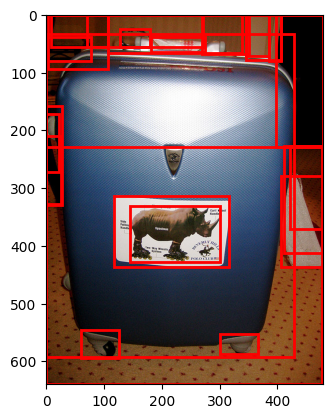

In [5]:
# Visualize the boxes for first image

my_img = box_img[150]
my_boxes = img_to_box_id[my_img]
my_boxes = [boxes[i] for i in my_boxes]


import matplotlib.pyplot as plt

def visualize_boxes(img, boxes):
    img = Image.open(os.path.join(img_dir, img))
    plt.imshow(img)
    width, height = img.size
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        plt.gca().add_patch(plt.Rectangle((x_min * width, y_min * height), (x_max - x_min) * width, (y_max - y_min) * height, fill=False, edgecolor='red', linewidth=2))
    plt.show()

visualize_boxes(my_img, my_boxes)



In [6]:
import math
import faiss

k_coarse = 1024
m = 256
cluster_bits = 8
n_probes = 3
dim = box_embeds[0].shape[0]

box_embeds_arr = np.array(box_embeds)

sample_points = int(256*(math.sqrt(len(box_embeds))))
print(f"Sample points: {sample_points}")


sample_indices = np.random.choice(len(box_embeds), sample_points, replace=False)
kmeans = faiss.Kmeans(dim, k_coarse, niter=20, verbose=True)
kmeans.train(box_embeds_arr[sample_indices])
d, ids = kmeans.index.search(box_embeds_arr, 1)

centroids = kmeans.centroids[ids].squeeze()
residuals = box_embeds_arr - centroids
# residuals = box_embeds_arr

pqq = faiss.ProductQuantizer(dim, m, cluster_bits)
pqq.train(residuals)




Sample points: 556734
Sampling a subset of 262144 / 556734 for training
Clustering 262144 points in 512D to 1024 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.39 s
  Iteration 19 (6.21 s, search 6.04 s): objective=48986.8 imbalance=1.193 nsplit=0       


In [7]:
from bitpacking_2 import NumpyBitpackedDict
from tqdm import tqdm

# packd = NumpyBitpackedDict(initial_size=1024, load_factor=0.7)
packd = {}

box_codes = pqq.compute_codes(residuals)
box_coarse = []

coarse_lists = []
for i in range(k_coarse):
    coarse_lists.append({
        # 'embeds': [],
        'codes': [],
        'boxes': [],
        'seg_ids': [],
        'img': [],
        'offset': [],
    })

packd_to_idx = {}
for i in tqdm(range(len(box_embeds))):
    coarse_idx = ids[i][0]
    # coarse_lists[coarse_idx]['embeds'].append(box_embeds[i])
    box_coarse.append(coarse_idx)
    img_idx = img_to_idx[box_img[i]]
    coarse_lists[coarse_idx]['codes'].append(box_codes[i])
    coarse_lists[coarse_idx]['boxes'].append(boxes[i])
    coarse_lists[coarse_idx]['seg_ids'].append(box_seg_ids[i])
    coarse_lists[coarse_idx]['img'].append(box_img[i])
    # packd_to_idx[pack_data(img_idx, coarse_idx)] = i
    if (img_idx, coarse_idx) not in packd:
        packd[img_idx, coarse_idx] = [box_codes[i]]
        coarse_lists[coarse_idx]['offset'].append(0)
    else:
        coarse_lists[coarse_idx]['offset'].append(len(packd[img_idx, coarse_idx]))
        packd[img_idx, coarse_idx].append(box_codes[i])


100%|██████████| 4729509/4729509 [00:13<00:00, 342649.84it/s]


In [8]:
import numpy as np
import math
from enum import IntEnum
from tqdm import tqdm

# Define 8 cardinal directions as an enum
class Direction(IntEnum):
    RIGHT = 0
    UPPER_RIGHT = 1
    UP = 2
    UPPER_LEFT = 3
    LEFT = 4
    LOWER_LEFT = 5
    DOWN = 6
    LOWER_RIGHT = 7

# Direction vectors for reference (normalized)
DIRECTION_VECTORS = [
    (1.0, 0.0),       # RIGHT
    (0.7071, 0.7071), # UPPER_RIGHT
    (0.0, 1.0),       # UP
    (-0.7071, 0.7071),# UPPER_LEFT
    (-1.0, 0.0),      # LEFT
    (-0.7071, -0.7071),# LOWER_LEFT
    (0.0, -1.0),      # DOWN
    (0.7071, -0.7071) # LOWER_RIGHT
]

def get_bbox_center(bbox):
    """Calculate the center point of a bounding box."""
    x_min, y_min, x_max, y_max = bbox
    return ((x_min + x_max) / 2, (y_min + y_max) / 2)

def get_bbox_dimensions(bbox):
    """Calculate width and height of a bounding box."""
    x_min, y_min, x_max, y_max = bbox
    width = x_max - x_min
    height = y_max - y_min
    return width, height

def get_direction(center1, center2):
    """
    Determine the direction from center1 to center2.
    Returns the Direction enum value and similarity score.
    """
    # Vector from center1 to center2
    dx = center2[0] - center1[0]
    dy = center2[1] - center1[1]
    
    # Handle zero distance case
    magnitude = math.sqrt(dx**2 + dy**2)
    if magnitude < 1e-6:
        return None, 0.0
    
    # Normalize the vector
    dx /= magnitude
    dy /= magnitude
    
    # Find the closest direction by computing cosine similarity
    max_similarity = -1
    best_direction = None
    
    for dir_idx, dir_vector in enumerate(DIRECTION_VECTORS):
        # Compute dot product (cosine similarity for normalized vectors)
        similarity = dx * dir_vector[0] + dy * dir_vector[1]
        
        if similarity > max_similarity:
            max_similarity = similarity
            best_direction = Direction(dir_idx)
    
    return best_direction, max_similarity

# Write some tests for direction
# def create_pair(angle):
#     return [(0,0,0,0), (0,0, math.cos(angle), math.sin(angle))]

# tests = [
#     [*create_pair(0), Direction.RIGHT],
#     [*create_pair(math.pi/4), Direction.UPPER_RIGHT],
#     [*create_pair(math.pi - math.pi/4), Direction.UPPER_LEFT],
# ]

# for i, test in enumerate(tests):
#     bbox1, bbox2, expected_direction = test
#     direction, similarity = get_direction(get_bbox_center(bbox1), get_bbox_center(bbox2))
#     assert direction == expected_direction, f"Test:{i}, Expected {expected_direction}, got {direction}"


def are_bboxes_interacting(bbox1, bbox2, buffer_factor=2.5):
    """
    Determine if two bounding boxes are close enough to interact.
    Returns: (is_interacting, direction)
    
    buffer_factor increases the minimum interaction distance.
    """
    # Get centers and dimensions
    center1 = get_bbox_center(bbox1)
    center2 = get_bbox_center(bbox2)
    width1, height1 = get_bbox_dimensions(bbox1)
    width2, height2 = get_bbox_dimensions(bbox2)
    
    # Use the larger of the two bounding boxes for distance calculation
    # max_width = max(width1, width2)
    # max_height = max(height1, height2)
    max_width = min(width1, width2)
    max_height = min(height1, height2)
    
    # Calculate direction
    direction, similarity = get_direction(center1, center2)
    if direction is None:
        return False, None
    
    # Calculate actual distance
    dx = center2[0] - center1[0]
    dy = center2[1] - center1[1]
    distance = math.sqrt(dx**2 + dy**2)
    
    # Calculate threshold distance based on direction
    if direction in [Direction.RIGHT, Direction.LEFT]:
        # Horizontal directions use width
        threshold = max_width * buffer_factor
    elif direction in [Direction.UP, Direction.DOWN]:
        # Vertical directions use height
        threshold = max_height * buffer_factor
    else:
        # Diagonal directions - use whichever dimension is "closer"
        horizontal_ratio = abs(dx) / max_width if max_width > 0 else float('inf')
        vertical_ratio = abs(dy) / max_height if max_height > 0 else float('inf')
        
        if horizontal_ratio <= vertical_ratio:
            threshold = max_width * buffer_factor
        else:
            threshold = max_height * buffer_factor

    # print(f"distance: {distance}, threshold: {threshold}, direction: {direction}")
    
    # Check if close enough
    return distance <= threshold, direction



In [9]:
# coarse_lists[coarse_idx]['codes'].append(box_codes[i])
# coarse_lists[coarse_idx]['boxes'].append(boxes[i])
# coarse_lists[coarse_idx]['seg_ids'].append(box_seg_ids[i])
# coarse_lists[coarse_idx]['img'].append(box_img[i])

# print(len(cl['seg_ids']), len(cl['codes']), len(cl['boxes']), len(cl['seg_ids']), len(cl['img']))
count = 0

for img in img_to_box_id.keys():
    boxes = img_to_box_id[img]
    for box_idx in boxes:
        box = boxes[box_idx]
        for other_box_idx in boxes:
            if box_idx == other_box_idx or not are_bboxes_interacting(box, boxes[other_box_idx]):
                continue

            count += 1
            if count == 5:
                break




TypeError: cannot unpack non-iterable int object

In [85]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from PIL import Image
import os
import random


def visualize_interactive_boxes(img, boxes_dict, img_dir, buffer_factor=0.55):
    """
    Visualize boxes with clear text labels for interacting pairs.
    
    Args:
        img (str): Image filename
        boxes_dict (dict): Dictionary mapping box_idx to box coordinates
        img_dir (str): Directory containing the images
    """
    # Load the image
    img_path = os.path.join(img_dir, img)
    image = Image.open(img_path)
    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    width, height = image.size
    
    # Find all interacting pairs
    interacting_pairs = []
    for box_idx1, box1 in boxes_dict.items():
        for box_idx2, box2 in boxes_dict.items():
            is_interact, _ = are_bboxes_interacting(box1, box2, buffer_factor=buffer_factor)
            if box_idx1 != box_idx2 and is_interact:
                # Add the pair (ensuring order doesn't matter for comparison)
                pair = tuple(sorted([box_idx1, box_idx2]))
                if pair not in interacting_pairs:
                    interacting_pairs.append(pair)
    
    # Create a color map for the pairs
    colors = list(mcolors.TABLEAU_COLORS.values())
    if len(interacting_pairs) > len(colors):
        # Generate more colors if needed
        more_colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(len(interacting_pairs) - len(colors))]
        colors.extend(more_colors)
    
    # Map each pair to a color and a pair ID
    pair_colors = {}
    pair_ids = {}
    for i, pair in enumerate(interacting_pairs):
        pair_colors[pair] = colors[i % len(colors)]
        pair_ids[pair] = f"Pair {i+1}"
    
    # Create a mapping from box_idx to all its pairs
    box_to_pairs = {}
    for pair in interacting_pairs:
        box_idx1, box_idx2 = pair
        if box_idx1 not in box_to_pairs:
            box_to_pairs[box_idx1] = []
        if box_idx2 not in box_to_pairs:
            box_to_pairs[box_idx2] = []
        box_to_pairs[box_idx1].append(pair_ids[pair])
        box_to_pairs[box_idx2].append(pair_ids[pair])
    
    # Draw all boxes
    for box_idx, box in boxes_dict.items():
        x_min, y_min, x_max, y_max = box
        
        # Determine if this box is part of any pairs
        if box_idx in box_to_pairs:
            # This box is interactive
            # Draw multiple lines for each pair this box belongs to
            for i, pair_id in enumerate(box_to_pairs[box_idx]):
                # Find the pair this ID belongs to
                for pair, pid in pair_ids.items():
                    if pid == pair_id:
                        color = pair_colors[pair]
                        break
                
                # Draw the box with a slight offset for each pair (to make multiple pairs visible)
                offset = i * 2  # pixels
                rect = plt.Rectangle(
                    (x_min * width - offset, y_min * height - offset), 
                    (x_max - x_min) * width + 2*offset, 
                    (y_max - y_min) * height + 2*offset, 
                    fill=False, edgecolor=color, linewidth=2
                )
                plt.gca().add_patch(rect)
            
            # Add label with pair information
            pairs_text = ", ".join(box_to_pairs[box_idx])
            plt.text(
                x_min * width, 
                y_min * height - 15, 
                f'Box {box_idx} in {pairs_text}', 
                color='black',
                fontsize=10,
                backgroundcolor='white'
            )
        # else:
        #     # Non-interacting box
        #     rect = plt.Rectangle(
        #         (x_min * width, y_min * height), 
        #         (x_max - x_min) * width, 
        #         (y_max - y_min) * height, 
        #         fill=False, edgecolor='gray', linewidth=2
        #     )
        #     plt.gca().add_patch(rect)
        #     plt.text(
        #         x_min * width, 
        #         y_min * height - 15, 
        #         f'Box {box_idx} (no pairs)', 
        #         color='gray',
        #         fontsize=10,
        #         backgroundcolor='white'
        #     )
    
    # Add a legend for pairs
    legend_elements = []
    for pair, pair_id in pair_ids.items():
        color = pair_colors[pair]
        box_idx1, box_idx2 = pair
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=f'{pair_id}: Box {box_idx1} & Box {box_idx2}'))
    
    # Add legend for non-interacting boxes if any
    # non_interacting = [box_idx for box_idx in boxes_dict if box_idx not in box_to_pairs]
    # if non_interacting:
        # legend_elements.append(plt.Line2D([0], [0], color='gray', lw=4, label=f'Non-interacting: {non_interacting}'))
    
    plt.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    plt.title(f'Interactive Boxes in {img}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print a summary of the interactions
    print("\nInteraction Summary:")
    print(f"Total boxes: {len(boxes_dict)}")
    print(f"Total interacting pairs: {len(interacting_pairs)}")
    for pair, pair_id in pair_ids.items():
        box_idx1, box_idx2 = pair
        print(f"{pair_id}: Box {box_idx1} interacts with Box {box_idx2}")


# my_img = box_img[100]
# my_boxes_dict = {box_id: boxes[box_id] for box_id in img_to_box_id[my_img]}
# visualize_interactive_boxes(my_img, my_boxes_dict, img_dir, buffer_factor=0.55)


In [10]:
from tqdm.notebook import tqdm
from collections import defaultdict
# my_img = box_img[350]
# my_boxes_dict = {box_id: boxes[box_id] for box_id in img_to_box_id[my_img]}
# all_imgs = list(img_to_box_id.keys())
# random.shuffle(all_imgs)
concept_concept_dir_ivf = defaultdict(list)
fast_pickle_path = "concept_concept_dir_msakclip_ivf.pkl"
if os.path.exists(fast_pickle_path):
    print("Load from file")
    with open(fast_pickle_path, "rb") as f:
        concept_concept_dir_ivf = pickle.load(f)
else:
    print("Load manual (long ):)")
    # for img in all_imgs[:5]:
    for img in tqdm(img_to_box_id.keys()):
        boxes_ = img_to_box_id[img]
        for i in range(len(boxes_)):
            box1 = boxes_[i]
            for j in range(i+1, len(boxes_)):
                box2 = boxes_[j]
                is_interact, direction = are_bboxes_interacting(boxes[box1], boxes[box2], buffer_factor=0.9)
                if not is_interact:
                    continue
                # print(f"Box {i} and Box {j} are interacting in direction {direction}")
                box1_concept = box_coarse[box1]
                box2_concept = box_coarse[box2]
                interaction_key = (box1_concept, box2_concept, direction) if box1_concept < box2_concept else (box2_concept, box1_concept, direction)
                concept_concept_dir_ivf[interaction_key].append(img)

Load from file


In [136]:
with open("concept_concept_dir_msakclip_ivf.pkl", "wb") as f:
    pickle.dump(concept_concept_dir_ivf, f)


In [38]:
from pympler import asizeof

asizeof.asizeof(np.array([1, 2, 3, 4, 5, 6, 7, 8]).astype(np.int32)) - 8*32/8

128.0

In [36]:
total_bytes = 0
total_bytes += len(concept_concept_dir_ivf) * 32 # Assume 32 bits for key
for arr in concept_concept_dir_ivf.values():
    total_bytes += len(arr) * 32 # Assume 32 bits for value
print(total_bytes / 8 / 1024 / 1024)


34.41539764404297


In [43]:
img_to_img_id = {}
for id, img in enumerate(img_to_box_id.keys()):
    img_to_img_id[img] = id


In [ ]:
from pyroaring import BitMap

total_bytes_roaring = len(concept_concept_dir_ivf) * 32 /8# Assume 32 bits for key
# for arr in concept_concept_dir_ivf.values():
for interaction_key, arr in concept_concept_dir_ivf.items():
    (box1_concept, box2_concept, direction) = interaction_key
    # (img_id, offset)
    new_arr = [img_to_img_id[img] for img in arr]
    roar = BitMap(new_arr)
    
    total_bytes_roaring += asizeof.asizeof(roar)

print(total_bytes_roaring / 1024 / 1024)

44.66059112548828


In [14]:
print(len(concept_concept_dir_ivf))

1274268


In [ ]:
from pympler import asizeof

print(asizeof.asizeof(concept_concept_dir_ivf))
# len(concept_concept_dir_ivf)
# concept-concept-direction filter
# (img-interaction-type) packed -> [codes]

337981600


In [45]:
len(concept_concept_dir_ivf)*32 / 1024 /1024

38.8875732421875

In [144]:
num_imgs = 0
for arr in concept_concept_dir_ivf.values():
    num_imgs += 1

In [146]:
print((num_imgs*32 + len(concept_concept_dir_ivf)*32) / 8 / 1024 /1024)

9.721893310546875
